In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

ngrip_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/NGRIP/density.txt', delimiter='\t')

edc_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/EDC/density.txt', delim_whitespace=True, skiprows=1, usecols=[0,1])

df_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/DF/density.txt', delimiter='\t', skiprows=1, usecols=[0,1])

edml_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/EDML/density.txt', delim_whitespace=True, skiprows=1, usecols=[0,1])

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_22964/3936547742.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edc_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/EDC/density.txt', delim_whitespace=True, skiprows=1, usecols=[0,1])
/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_22964/3936547742.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edml_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/EDML/density.txt', delim_whitespace=True, skiprows=1, usecols=[0,1])


0.92040266318745


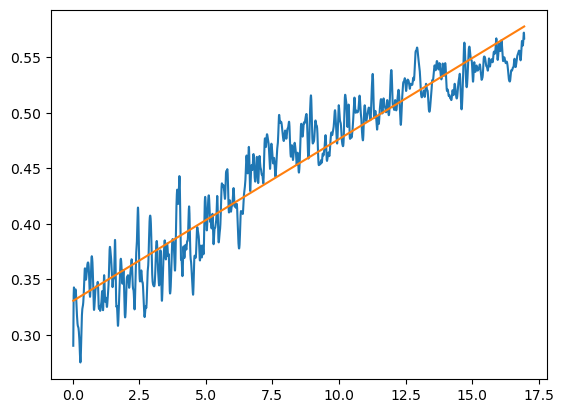

In [71]:
slope, intercept, r, p, se = sp.linregress(ngrip_dens['depth'], ngrip_dens['rel_dens'])


plt.plot(ngrip_dens['depth'], ngrip_dens['rel_dens'])
plt.plot(ngrip_dens['depth'], (ngrip_dens['depth']*slope)+intercept)

print(r**2)

       depth  rel_dens
0      0.275  0.363636
1      0.825  0.363636
2      1.375  0.345455
3      1.925  0.327273
4      2.475  0.400000
..       ...       ...
257  141.625  0.963636
260  143.275  0.963636
263  144.925  0.963636
266  146.575  0.963636
271  149.325  0.963636

[257 rows x 2 columns]
0.9369593365786517


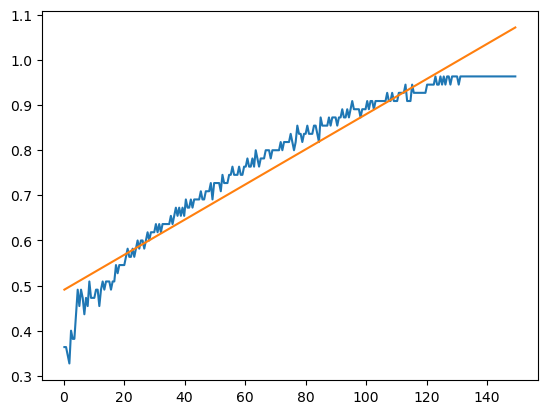

In [72]:
edc_dens_new=edc_dens[edc_dens['rel_dens'] <= 0.98]

print(edc_dens_new)


slope, intercept, r, p, se = sp.linregress(edc_dens_new['depth'], edc_dens_new['rel_dens'])


plt.plot(edc_dens_new['depth'], edc_dens_new['rel_dens'])
plt.plot(edc_dens_new['depth'], (edc_dens_new['depth']*slope)+intercept)

print(r**2)

     depth  rel_dens
0        0  0.381679
1        1  0.389991
2        2  0.398367
3        3  0.406802
4        4  0.415294
..     ...       ...
164    164  0.977934
165    165  0.978382
166    166  0.978815
167    167  0.979232
168    168  0.979636

[169 rows x 2 columns]
0.9122771703242475


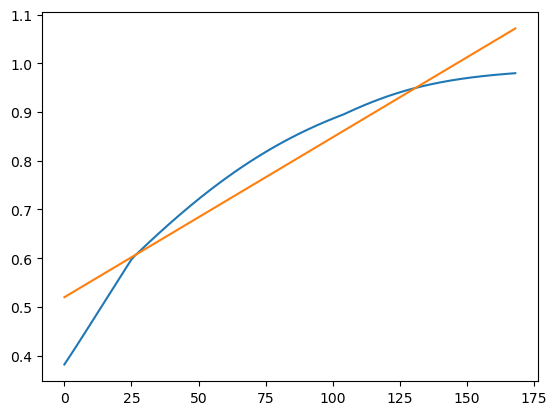

In [73]:
df_dens_new=df_dens[df_dens['rel_dens'] <= 0.98]

print(df_dens_new)


slope, intercept, r, p, se = sp.linregress(df_dens_new['depth'], df_dens_new['rel_dens'])


plt.plot(df_dens_new['depth'], df_dens_new['rel_dens'])
plt.plot(df_dens_new['depth'], (df_dens_new['depth']*slope)+intercept)

print(r**2)

In [74]:
#Not Using EDML because it approaches 1 linearly then switches. Just using the other two.

# edml_dens_new=edml_dens[edml_dens['rel_dens'] < 0.985]

# print(edml_dens_new)


# slope, intercept, r, p, se = sp.linregress(edml_dens_new['depth'], edml_dens_new['rel_dens'])


# plt.plot(edml_dens_new['depth'], edml_dens_new['rel_dens'])
# plt.plot(edml_dens_new['depth'], (edml_dens_new['depth']*slope)+intercept)

# print(r**2)

Optimal scale (a): 0.0116, shift (b): -0.0477
0.011645454321738757 -0.04766370434380631


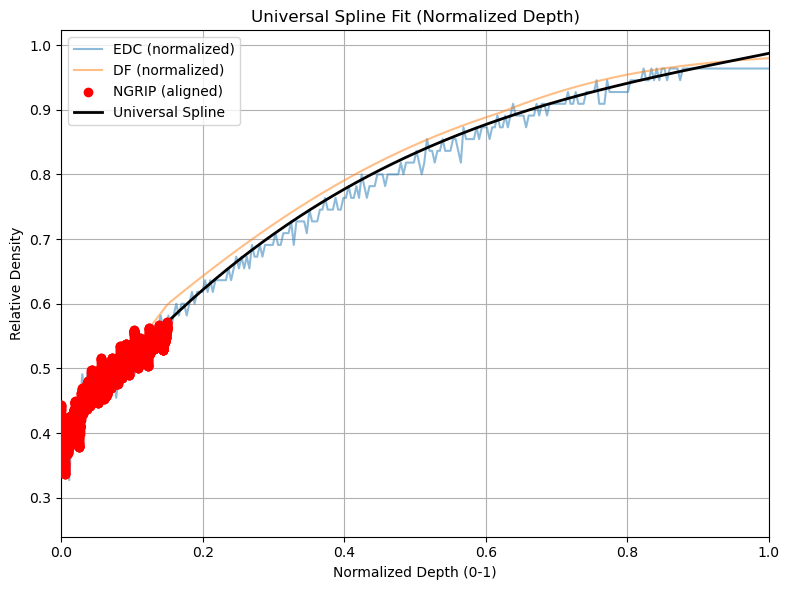

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Normalizes array for range from 0-1 (difference between min and max divided)
def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (x.max() - x.min())

# This takes the full cores (so EDC/DF), normalizes, builds new array for all depths and densities
# Multiple cores are flattened into one array, then they are sorted by depth
def build_universal_spline(full_cores):
    norm_depths = []
    norm_densities = []

    for core in full_cores:
        dep = normalize(core['depth'])
        den = core['rel_dens']
        norm_depths.append(dep)
        norm_densities.append(den)

    all_norm_depths = np.concatenate(norm_depths)
    all_norm_densities = np.concatenate(norm_densities)

    # Sort by depth - argsort creates an array of indices that will sort the depths array, so can also be applied to densities.
    sort_idx = np.argsort(all_norm_depths)
    all_norm_depths_sorted = all_norm_depths[sort_idx]
    all_norm_densities_sorted = all_norm_densities[sort_idx]

    # spline fit a smooth curve that follows the data, but allows for a small amount of error (s=0.01)
    spline = UnivariateSpline(all_norm_depths_sorted, all_norm_densities_sorted, s=0.10)
    return spline

#create the spline
spline = build_universal_spline([edc_dens_new, df_dens_new])

#aligning NGRIP: ------------

#calculates residuals with a) scale/stretch and b) shift/offset
def residuals(ab, depth, density, spline):
    a, b = ab
    norm_depth = a * depth + b
    spline_vals = spline(norm_depth)
    return spline_vals - density

#removes depths that would be outside the normalized depth range
def clipped_residuals(ab, depth, density, spline):
    a, b = ab
    norm_depth = a * depth + b
    mask = (norm_depth >= 0) & (norm_depth <= 1)
    return residuals(ab, depth[mask], density[mask], spline)

# initial guess for a will be the inverse of the max depth and no shift. Init guess creates a potential 0-1 scaling fit.
ngrip_depth = ngrip_dens['depth'].values
ngrip_dens_values = ngrip_dens['rel_dens'].values
initial_guess = [1 / ngrip_depth.max(), 0]

#uses scipy curve_fit from scipy to find the best a and b to minimize differences
opt_params, _ = curve_fit(lambda d, a, b: spline(a * d + b), ngrip_depth, ngrip_dens_values, p0=initial_guess)
a_opt, b_opt = opt_params
print(f"Optimal scale (a): {a_opt:.4f}, shift (b): {b_opt:.4f}")

#apploies the transformation
ngrip_dens['norm_depth'] = a_opt * ngrip_dens['depth'] + b_opt
print(a_opt, b_opt)

# create plot -------

# creating a plot with normalized depths
plt.figure(figsize=(8,6))

# Plot normalized full cores
plt.plot(normalize(edc_dens_new["depth"]), edc_dens_new["rel_dens"], label="EDC (normalized)", alpha=0.5)
plt.plot(normalize(df_dens_new["depth"]), df_dens_new["rel_dens"], label="DF (normalized)", alpha=0.5)

plt.scatter(ngrip_dens['norm_depth'], ngrip_dens['rel_dens'], label="NGRIP (aligned)", color='red', zorder=5)

# Evaluate spline across 0 to 1 normalized depth
x_spline = np.linspace(0, 1, 300)
y_spline = spline(x_spline)
plt.plot(x_spline, y_spline, label="Universal Spline", color='black', linewidth=2)

plt.xlabel("Normalized Depth (0-1)")
plt.ylabel("Relative Density")
plt.xlim(0,1)
plt.title("Universal Spline Fit (Normalized Depth)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



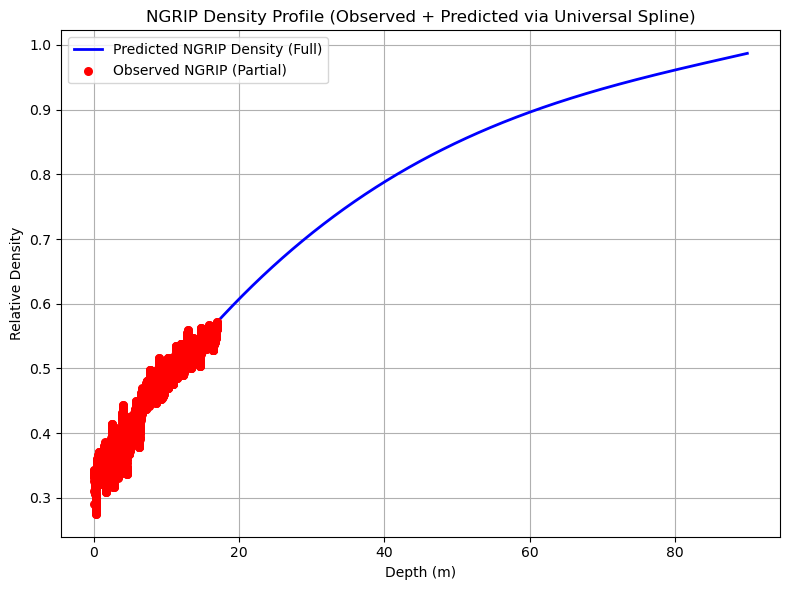

In [76]:
#Generate full depth range
max_depth = 2428  # or use ngrip_dens['depth'].max() if you're unsure
ngrip_depth_resolution = max_depth*100
ngrip_full_depths = np.linspace(0, max_depth, ngrip_depth_resolution) #this is 0.5x the original resolution (200/m)

#apply alignment transformation for spline
ngrip_norm_depths = a_opt * ngrip_full_depths + b_opt

#masking out anything outside of the spline range
valid_mask = (ngrip_norm_depths >= 0) & (ngrip_norm_depths <= 1)
ngrip_valid_depths = ngrip_full_depths[valid_mask]
ngrip_valid_norm_depths = ngrip_norm_depths[valid_mask]

#predict depths from the spline
ngrip_predicted_densities = spline(ngrip_valid_norm_depths)

# Step 5: Create a DataFrame of the predicted full profile
ngrip_filled = pd.DataFrame({
    "depth": ngrip_valid_depths,
    "rel_dens": ngrip_predicted_densities
})

#create plot
plt.figure(figsize=(8, 6))

# Plot predicted full profile
plt.plot(ngrip_filled["depth"], ngrip_filled["rel_dens"],
         label="Predicted NGRIP Density (Full)", color='blue', linewidth=2)

# Plot original observed partial data
plt.scatter(ngrip_dens["depth"], ngrip_dens["rel_dens"],
            label="Observed NGRIP (Partial)", color='red', s=30, zorder=5)

plt.xlabel("Depth (m)")
plt.ylabel("Relative Density")
plt.title("NGRIP Density Profile (Observed + Predicted via Universal Spline)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [81]:
# lets get slope for each meter first, and calculate how much it is changing to extend out to 1

slopes_per_m = []
for i in range(80,90):
    mask = np.logical_and(ngrip_filled['depth']>i-1, ngrip_filled['depth']<=i)
    segment = ngrip_filled[mask]
    m, _ = np.polyfit(segment['depth'], segment['rel_dens'], 1)
    slopes_per_m.append(m)

###decided not to do this because it spirals fast
# slope_diff_per_m = [] #calculate change in slope per m
# for i in range(len(slopes_per_m)):
#     if i == 0:
#         continue
#     temp = slopes_per_m[i] - slopes_per_m[i-1]
#     slope_diff_per_m.append(temp)

# print(slope_diff_per_m)
# seems to operate on the 1e-5 scale, so I'll adjust the slope by -2.5e-5 per m

#take the final slope to start with
final_slope = slopes_per_m[-1]

#make a new one to not screw up original variable
modify_ngrip_filled = ngrip_filled.copy(deep=True)

add_depth_val = (1/(ngrip_depth_resolution/max_depth)) #how much between rows

i=0
while modify_ngrip_filled['rel_dens'].iloc[-1] < 1:

    new_depth = modify_ngrip_filled['depth'].iloc[-1] + add_depth_val

    new_dens = modify_ngrip_filled['rel_dens'].iloc[-1] + ((final_slope*(add_depth_val/1))) #this adds it by the final slope adjusted by each iteration by the predetermined decrease in slope values

    new_row = pd.DataFrame([{'depth': new_depth, 'rel_dens': new_dens}])
    modify_ngrip_filled = pd.concat([modify_ngrip_filled, new_row], ignore_index=True)
    i+=1

modify_ngrip_filled.loc[modify_ngrip_filled.index[-1], 'rel_dens'] = 1 #set final to 1

modify_ngrip_filled

,depth,rel_dens
0,4.100017,0.390645
1,4.110017,0.390806
2,4.120017,0.390966
3,4.130017,0.391127
4,4.140017,0.391287
...,...,...
9090,95.000371,0.999920
9091,95.010371,0.999945
9092,95.020371,0.999971
9093,95.030371,0.999996


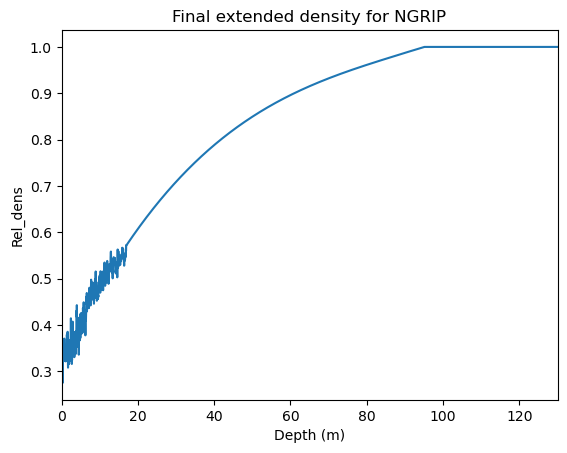

In [106]:
#final modification to keep the original data points and extend properly

maximum_original_depth = ngrip_dens['depth'].max()
modified_tail = modify_ngrip_filled[modify_ngrip_filled['depth'] > maximum_original_depth]
ngrip_dens_trimmed = ngrip_dens.iloc[:, :2]

#combine the data
ngrip_combined = pd.concat([ngrip_dens_trimmed, modified_tail], ignore_index=True)
ngrip_combined = ngrip_combined.sort_values('depth').reset_index(drop=True)

#extend length of dataset to max depth
remaining_depth = max_depth - ngrip_combined['depth'].iloc[-1]
# Compute how many new depth points to add based on resolution, converting to integer and subtracting one.
remaining_rows = remaining_depth / add_depth_val
remaining_rows = int(remaining_rows-1)

# Get the last depth value from the combined dataset as starting point for extension.
start_depth = ngrip_combined['depth'].iloc[-1]

# Generate evenly spaced depth values from just beyond the last combined depth to the max depth.
depths = np.linspace(start_depth + add_depth_val, 
                     start_depth + (add_depth_val * remaining_rows), 
                     remaining_rows)

remaining_df = pd.DataFrame({
    'depth': depths,
    'rel_dens': 1
})

final_df = pd.concat([ngrip_combined, remaining_df], ignore_index=True)
# Append the new filled data to the combined dataset and reset the index.


plt.plot(final_df['depth'], final_df['rel_dens'])
plt.xlim(0,130)
plt.title('Final extended density for NGRIP')
plt.xlabel('Depth (m)')
plt.ylabel('Rel_dens')

final_df.to_csv('/Users/quinnmackay/Documents/GitHub/paleochrono/BICC2025/NGRIP/python code/new_ngrip_density.txt', sep='\t', index=False)
